In [1]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os
os.environ["OPENAI_API_KEY"] = ""

loader = TextLoader("./data/testContext.txt")
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=350,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)
chunks = text_splitter.split_documents(docs)

In [2]:
chunks[0]

Document(metadata={'source': './data/testContext.txt'}, page_content='The Eiffel Tower is a wrought-iron lattice tower located in Paris, France.\nIt was designed by the French engineer Gustave Eiffel and was completed in 1889 as the entrance arch to the 1889 World’s Fair.')

In [3]:
# RAGAS expects a file_name dict as key
for document in chunks:
    document.metadata["file_name"] = document.metadata["source"]

In [21]:
from ragas.testset import TestsetGenerator
from langchain_openai import ChatOpenAI
from langchain_ollama import OllamaEmbeddings
from langchain_ollama.llms import OllamaLLM

embeddings = OllamaEmbeddings(model="nomic-embed-text")
model = OllamaLLM(model="llama3.2:3b")
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))
generator_embeddings = LangchainEmbeddingsWrapper(OllamaEmbeddings(model="nomic-embed-text"))
judge = ChatOpenAI(model="gpt-4o-mini")

generator = TestsetGenerator.from_langchain(
    embedding_model=embeddings, llm=model, testset_size= 8
)

testset = generator.generate_with_langchain_docs(
    chunks
)

TypeError: TestsetGenerator.from_langchain() got an unexpected keyword argument 'testset_size'

In [24]:
from ragas.testset import TestsetGenerator
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper

generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))
generator_embeddings = LangchainEmbeddingsWrapper(OllamaEmbeddings(model="nomic-embed-text"))
generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Generating Samples: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


In [25]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What significant event is associated with the ...,[The Eiffel Tower is a wrought-iron lattice to...,The Eiffel Tower was completed in 1889 as the ...,single_hop_specifc_query_synthesizer
1,What was the significance of the Eiffel Tower ...,[The Eiffel Tower is a wrought-iron lattice to...,The Eiffel Tower was completed in 1889 as the ...,single_hop_specifc_query_synthesizer
2,What is the significance of the Chryslur Buldi...,[The Eiffel Tower is a wrought-iron lattice to...,The Chrysler Building is significant as it was...,single_hop_specifc_query_synthesizer
3,How does the Eiffel Tower compare to the Chrys...,[The Eiffel Tower is a wrought-iron lattice to...,"The Eiffel Tower, completed in 1889, was the t...",single_hop_specifc_query_synthesizer
4,What significant event is associated with the ...,[The Eiffel Tower is a wrought-iron lattice to...,The Eiffel Tower was completed in 1889 as the ...,single_hop_specifc_query_synthesizer
5,How does the Eiffel Tower compare to the Chrys...,[The Eiffel Tower is a wrought-iron lattice to...,"The Eiffel Tower, designed by Gustave Eiffel a...",single_hop_specifc_query_synthesizer
6,What is the significance of New York City in r...,[The Eiffel Tower is a wrought-iron lattice to...,New York City is significant in relation to th...,single_hop_specifc_query_synthesizer
7,Eiffel Tower where in France?,[The Eiffel Tower is a wrought-iron lattice to...,"The Eiffel Tower is located in Paris, France.",single_hop_specifc_query_synthesizer
8,Wher is the Eiffel Tower located?,[The Eiffel Tower is a wrought-iron lattice to...,"The Eiffel Tower is located in Paris, France.",single_hop_specifc_query_synthesizer
9,What is the Eifel Tower?,[The Eiffel Tower is a wrought-iron lattice to...,The Eiffel Tower is a wrought-iron lattice tow...,single_hop_specifc_query_synthesizer


In [26]:
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI

embedding = OllamaEmbeddings(model="nomic-embed-text")
model = ChatOpenAI(model="gpt-4o-mini")

vectorstore = Chroma.from_documents(chunks, embedding)
retriever = vectorstore.as_retriever()

In [27]:
from langchain_core.prompts import PromptTemplate

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = PromptTemplate(template=template, input_variables=["context", "question"])

In [28]:
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [30]:
# questions = testset.to_pandas()["question"].to_list()
# ground_truth = testset.to_pandas()["ground_truth"].to_list()

import pandas as pd

df = pd.read_csv("qa.csv", delimiter=",")
questions = df["question"].tolist()
ground_truth = df["ground_truth"].tolist()

In [31]:
ground_truth

['The Eiffel Tower was designed by the French engineer Gustave Eiffel.',
 'The Eiffel Tower was completed in 1889 as the entrance arch to the 1889 World’s Fair.',
 'The Eiffel Tower is 330 meters (1,083 feet) tall.',
 'The Eiffel Tower was the tallest man-made structure until the Chrysler Building was finished in 1930.',
 'The third level of the Eiffel Tower has an observation deck.']

In [32]:
from datasets import Dataset

data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

for query in questions:
    data["question"].append(query)
    data["answer"].append(rag_chain.invoke(query))
    data["contexts"].append(
        [doc.page_content for doc in retriever.invoke(query)]
    )

dataset = Dataset.from_dict(data)

Number of requested results 4 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 4 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 4 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 4 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 4 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 4 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 4 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 4 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 4 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 4 is greater than number of elements in index 3, updating n_results = 3


In [33]:
first_entry = {
    "question": data["question"][0],
    "answer": data["answer"][0],
    "contexts": data["contexts"][0],
    "ground_truth": data["ground_truth"][0],
}
first_entry

{'question': 'Who designed the Eiffel Tower?',
 'answer': 'The Eiffel Tower was designed by the French engineer Gustave Eiffel.',
 'contexts': ['The Eiffel Tower is a wrought-iron lattice tower located in Paris, France.\nIt was designed by the French engineer Gustave Eiffel and was completed in 1889 as the entrance arch to the 1889 World’s Fair.',
  'Standing 330 meters (1,083 feet) tall, it was the tallest man-made structure in the world for 41 years until the Chrysler Building in New York City was finished in 1930.\nThe Eiffel Tower is one of the most-visited paid monuments in the world, attracting millions of visitors every year.',
  'It has three levels accessible to the public, with restaurants on the first two levels and an observation deck on the third level.'],
 'ground_truth': 'The Eiffel Tower was designed by the French engineer Gustave Eiffel.'}

In [36]:
from ragas import evaluate

your_evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))

from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset=dataset,
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
    llm=your_evaluator_llm
)

Evaluating: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


In [37]:
result.to_pandas()

,user_input,retrieved_contexts,response,reference,context_precision,context_recall,faithfulness,answer_relevancy
0,Who designed the Eiffel Tower?,[The Eiffel Tower is a wrought-iron lattice to...,The Eiffel Tower was designed by the French en...,The Eiffel Tower was designed by the French en...,1.0,1.0,1.0,1.000000
1,When was the Eiffel Tower completed?,[The Eiffel Tower is a wrought-iron lattice to...,The Eiffel Tower was completed in 1889.,The Eiffel Tower was completed in 1889 as the ...,1.0,1.0,1.0,1.000000
2,How tall is the Eiffel Tower?,"[Standing 330 meters (1,083 feet) tall, it was...","The Eiffel Tower is 330 meters (1,083 feet) tall.","The Eiffel Tower is 330 meters (1,083 feet) tall.",1.0,1.0,1.0,1.000000
3,What was the tallest man-made structure before...,"[Standing 330 meters (1,083 feet) tall, it was...","Before the Eiffel Tower, the tallest man-made ...",The Eiffel Tower was the tallest man-made stru...,1.0,1.0,0.0,0.966363
4,What is located on the third level of the tower?,"[It has three levels accessible to the public,...",The observation deck is located on the third l...,The third level of the Eiffel Tower has an obs...,1.0,1.0,1.0,0.849385


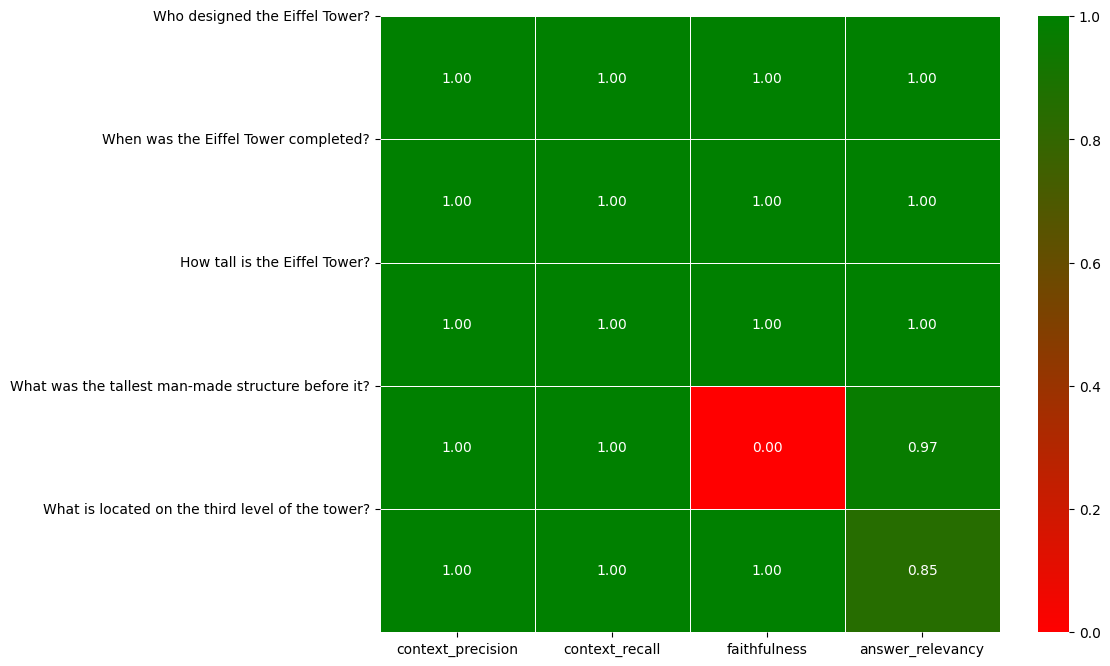

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = result.to_pandas()

heatmap_data = df[
    [
        "context_precision",
        "context_recall",
        "faithfulness",
        "answer_relevancy",
    ]
]

cmap = LinearSegmentedColormap.from_list("green_red", ["red", "green"])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=0.5, cmap=cmap)

plt.yticks(ticks=range(len(df["user_input"])), labels=df["user_input"], rotation=0)

plt.show()

In [50]:
pd.set_option('display.max_colwidth', None) 
print(df.iloc[0])

user_input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Who designed the Eiffel Tower?
retrieved_contexts    [The Eiffel Tower is a wrought-iron lattice tower located in Paris, France.\nIt was designed by the French engineer Gustave Eiffel and was completed in 1889 as the entrance arch to the 1889 World’s Fair., Standing 330 meters (1,083 feet) tall, it was the tallest man-made structure in the world for 41 years until the Chrysler Bui